In [1]:
import                 matplotlib.pylab as plt
import                             numpy as np
from                   shapely import geometry
from matplotlib.colors      import LightSource
import                                    math
import                              matplotlib
from       matplotlib.cm import ScalarMappable
from        matplotlib.colors import Normalize

In [2]:
boundary     = np.load('Downstream_Boundary.npy')  # Imposed downstream boundary
res          =                                  1  # Resolution [m] 
threshold    =             np.tan((np.pi*30)/180)  # Tangent of the threshold angle (taken here as 30 degree)

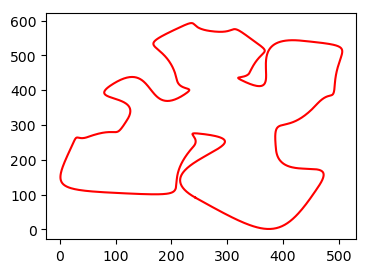

Total area in km^2 is  0.1657167171679175


In [3]:
pl  =  geometry.Polygon([[p[0], p[1]] for p in boundary])
fig =                plt.figure(figsize=(4, 3), dpi= 100)
plt.plot(pl.exterior.xy[0], pl.exterior.xy[1], c = "red")
plt.show()

print("Total area in km^2 is ", pl.area*(res*res)/10**6)

In [4]:
mesh_points_x     =                       math.ceil(np.max(boundary[:,1]))
mesh_points_y     =                       math.ceil(np.max(boundary[:,0]))
mesh_points_east  = np.linspace(0, math.ceil(np.max(boundary[:,0]))-1, math.ceil(np.max(boundary[:,0])))
mesh_points_north = np.linspace(0, math.ceil(np.max(boundary[:,1]))-1, math.ceil(np.max(boundary[:,1])))

# construct a rectangular mesh and eikonal elevation
eik_ele = np.zeros((mesh_points_y,mesh_points_x))

for i in range(mesh_points_east.shape[0]):
    for j in range(mesh_points_north.shape[0]):
        east  =         mesh_points_east[i]
        north =        mesh_points_north[j]
        point = geometry.Point(east, north)
        if pl.distance(point) == 0.0:
            eik_ele[i,j] = threshold*res*pl.exterior.distance(point)
            
print("In this block, I have measured the distance of interior points to the boundaries and\n \
multiplied that by the threshold angle to get the eikonal elevation field.")

eik_ele = np.fliplr(np.rot90(eik_ele,3))
print("I also flip the elevation matrix to match the axes convention of the shapely package.")

In this block, I have measured the distance of interior points to the boundaries and
 multiplied that by the threshold angle to get the eikonal elevation field.
I also flip the elevation matrix to match the axes convention of the shapely package.


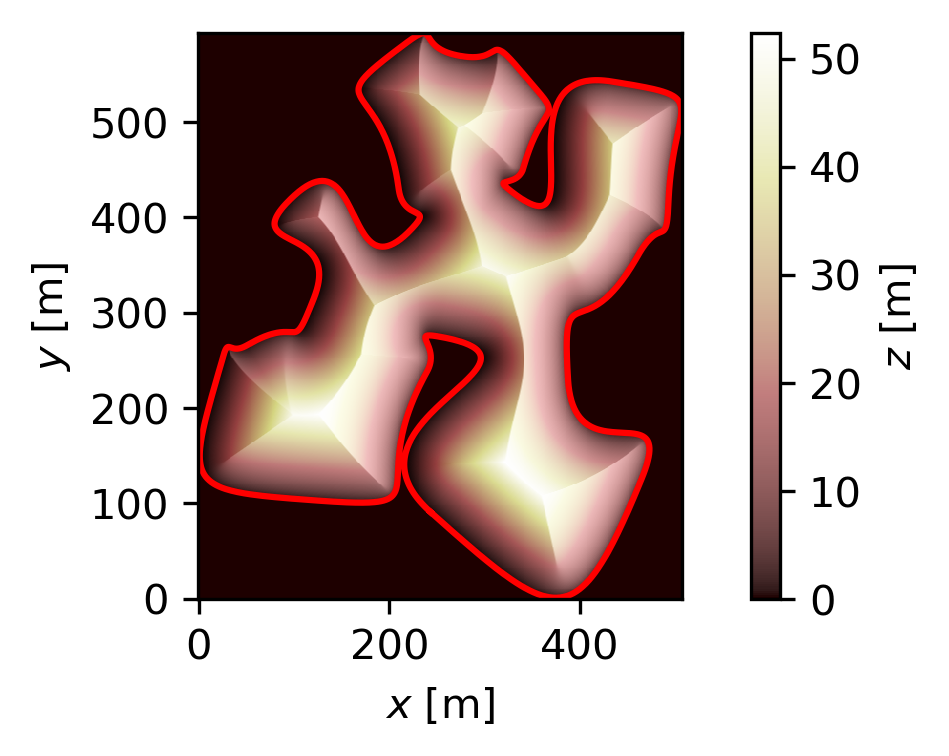

In this method of eikonal reconstruction, zero elevation (in black) is assigned to the points outside 
 the considered (red) boundary. The next cell replaces them with null values for better visualization.


In [5]:
# Plotting the eikonal topography, created in a rectangular domain of the same resolution.
ls   = LightSource(azdeg=90, altdeg=40)
norm = Normalize(0, np.nanmax(eik_ele))
cmap = plt.cm.pink
fig  = plt.figure(figsize=(3, 2.5), dpi=300)
ax1  = plt.subplot(111)
ax1.plot(pl.exterior.xy[0], pl.exterior.xy[1], c="red")
eikplot = ls.shade(np.ma.masked_invalid(eik_ele), cmap=cmap, blend_mode='soft', vert_exag=0.01, vmin=0, vmax=np.nanmax(eik_ele))
ax1.imshow(eikplot)
ax1.set_xlabel(r'$x$ [m]')
ax1.set_ylabel(r'$y$ [m]')

cmappable = ScalarMappable(norm=norm, cmap=cmap)
cmappable.set_array([])
colorbar  = plt.colorbar(cmappable, pad=0.1)
colorbar.set_label(r'$z$ [m]')
plt.gca().invert_yaxis()
plt.show()

print("In this method of eikonal reconstruction, zero elevation (in black) is assigned to the points outside \n \
the considered (red) boundary. The next cell replaces them with null values for better visualization.")

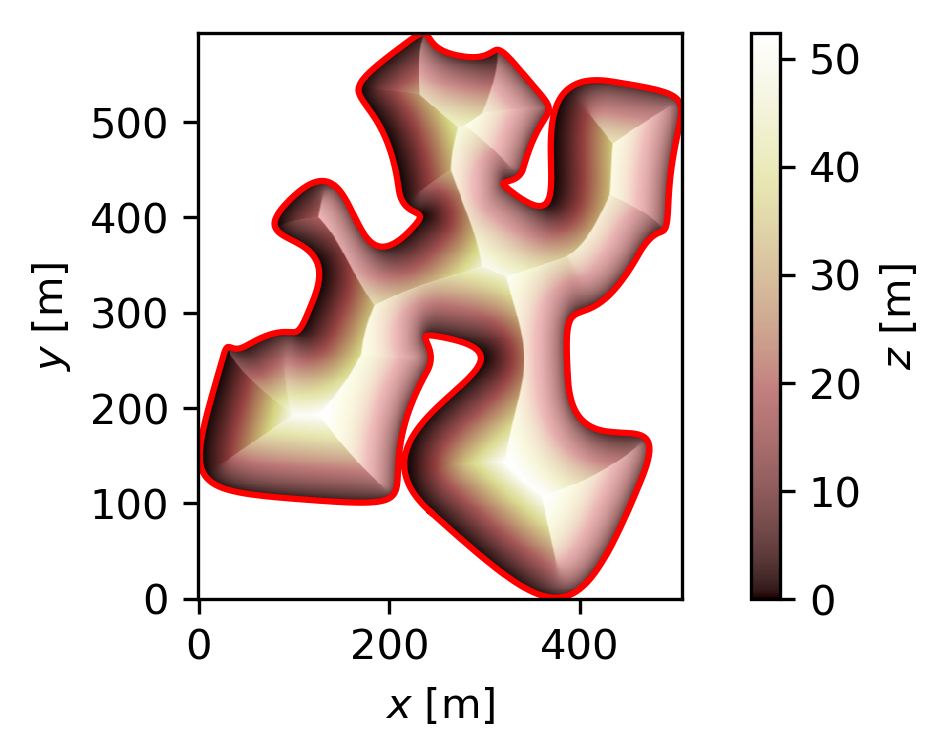

In [6]:
# Replacing the zero elevation outside the boundary with null values. 
minx, miny, maxx, maxy =                                                                        pl.bounds
minx, miny, maxx, maxy = int(np.ceil(minx)), int(np.ceil(miny)), int(np.floor(maxx)), int(np.floor(maxy))
box_patch              =                  [[x,y] for x in range(minx,maxx+1) for y in range(miny,maxy+1)]
pixels                 =                                                                               []

for pb in box_patch: 
    pt = geometry.Point(pb[0],pb[1])
    if(pl.contains(pt)):
        pixels.append([int(pb[0]), int(pb[1])])
        
pix_2d       =      np.asarray(pixels)
eik_ele_c    =  np.empty_like(eik_ele)
eik_ele_c[:] =                  np.nan

for i in range(pix_2d.shape[0]):
    eik_ele_c[pix_2d[i,1],pix_2d[i,0]] = eik_ele[pix_2d[i,1],pix_2d[i,0]]
    
# Plotting the final eikonal topography
ls   = LightSource(azdeg=90, altdeg=40)
norm = Normalize(0, np.nanmax(eik_ele_c))
cmap = plt.cm.pink
fig  = plt.figure(figsize=(3, 2.5), dpi=300)
ax1  = plt.subplot(111)
ax1.plot(pl.exterior.xy[0], pl.exterior.xy[1], c="red")
ax1.imshow(ls.shade(np.ma.masked_invalid(eik_ele_c), cmap=cmap, blend_mode='soft', vert_exag=0.1, vmin=0, vmax=np.nanmax(eik_ele_c)))
ax1.set_xlabel(r'$x$ [m]')
ax1.set_ylabel(r'$y$ [m]')
cmappable = ScalarMappable(norm=norm, cmap=cmap)
cmappable.set_array([])
colorbar = plt.colorbar(cmappable, pad=0.1)
colorbar.set_label(r'$z$ [m]')
plt.gca().invert_yaxis()
plt.show()